In [9]:
import numpy as np
import tensorflow as tf
from model import unet2d
import os, sys
import math

epochs = 5
field = "T"
scale = 1
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2, 3, 4, 5, 6, 7'

# Create save directory
checkpoint_dir = "./checkpoints/check_%s"%field
os.makedirs(checkpoint_dir, exist_ok=True)

boundaries = [1000, 3000]
values = [1e-2, 1e-3, 1e-4]
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
lr = 1e-4

img_w = img_h = 512
# theat_batch in [0, 60, 120, 180, 240]
# phi_batch in [-90, -60, -30, 0, 30, 60]
theta_phi = [[60, -30], [60, -60], [120, 30], [120, 60], [240, -30], [240, -60], [240, 30], [240, 60]]
theta_batch, phi_batch = theta_phi[3]

rot_arr = np.load("../../rots_npys/rot_arr_%d_%d.npy"%(theta_batch, phi_batch))
rerot_arr = np.load("../../rots_npys/rerot_arr_%d_%d.npy"%(theta_batch, phi_batch))

rearr = np.load("Split_Sky_Map/rearr_nside2048.npz")['data']
arr = np.load("Split_Sky_Map/arr_nside2048_192x512x512.npz")['data']

x_raw = np.load("../../train_dataset/%slen_5maps.npy"%field).reshape(-1, img_w, img_h, 1).astype('float32')
y_raw = np.load("../../train_dataset/%sunl_5maps.npy"%field).reshape(-1, img_w, img_h, 1).astype('float32')
x = []; y = []
for i in range(5):
    x.append(x_raw[(i*192):((i+1)*192), :, :, 0].reshape(-1)[rearr][rot_arr][arr])
    y.append(y_raw[(i*192):((i+1)*192), :, :, 0].reshape(-1)[rearr][rot_arr][arr])
x = np.array(x).reshape(-1, 512, 512, 1)
y = np.array(y).reshape(-1, 512, 512, 1)


y = scale * y

batch_size = 16; k_size = 3; dropout_rate = 0.2
TRAIN = 4; VAL = 5; TEST = 0

N_TRAIN = int(TRAIN*192); N_VAL  = int(VAL*192); N_TEST = int(TEST*192)

train_input = x[0:N_TRAIN]
valid_input = x[N_TRAIN:N_VAL]
test_input = x[N_TEST:N_VAL]

train_label = y[0:N_TRAIN]
valid_label = y[N_TRAIN:N_VAL]
test_label = y[N_TEST:N_VAL]

print("train_input, valid_input, test_input shape:", train_input.shape, valid_input.shape, test_input.shape)
print("train_label, valid_label, test_label shape:", train_label.shape, valid_label.shape, test_label.shape)

# ========== Checkpoint Configuration ==========
# Checkpoint file path (save every 100 epochs)
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_100.ckpt")
# Training status file
status_file = os.path.join(checkpoint_dir, "training_status.npy")

# Check if there are existing checkpoints
initial_epoch = 0
if os.path.exists(status_file):
    try:
        status = np.load(status_file, allow_pickle=True).item()
        initial_epoch = status['last_epoch']
        print(f"Resuming training from epoch {initial_epoch}")
        # Calculate last saved checkpoint
        last_saved_epoch = (initial_epoch // 100) * 100
        print(f"Last saved checkpoint at epoch {last_saved_epoch}")
    except:
        print("Error loading training status. Starting from scratch.")
        initial_epoch = 0
else:
    print("No checkpoint found. Starting new training.")

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Create model
    net = unet2d.unet2D(n_filters=256, conv_width=3, network_depth=3, n_channels=1, x_dim=img_h, dropout=0.2, \
                         growth_factor=2, batchnorm=True, momentum=0.9, epsilon=0.001, activation='relu', maxpool=True)
    net = net.build_model()
    net.compile(optimizer=tf.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999), 
                loss='logcosh', 
                metrics=['mae', 'mse'])
    
    # Load weights if checkpoint exists
    if os.path.exists(checkpoint_path + ".index"):
        net.load_weights(checkpoint_path)
        print(f"Loaded model weights from {checkpoint_path}")

# Custom callback: save training status and checkpoint every 100 epochs
class PeriodicCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_path, status_file):
        super().__init__()
        self.checkpoint_path = checkpoint_path
        self.status_file = status_file
        self.last_saved_epoch = 0
    
    def on_epoch_end(self, epoch, logs=None):
        current_epoch = epoch + 1  # epoch starts from 0, so +1
        
        # Save current training status
        current_status = {
            'last_epoch': current_epoch
        }
        np.save(self.status_file, current_status)
        
        # Save checkpoint every 100 epochs
        if current_epoch % 100 == 0:
            self.model.save_weights(self.checkpoint_path, overwrite=True)
            self.last_saved_epoch = current_epoch
            print(f"\nSaved checkpoint at epoch {current_epoch} to {self.checkpoint_path}")

# Callback list
callbacks = [
    PeriodicCheckpoint(checkpoint_path, status_file)
]

# Train model
history = net.fit(
    train_input, train_label,
    epochs=epochs,
    batch_size=batch_size,
    initial_epoch=initial_epoch,
    validation_data=(valid_input, valid_label),
    callbacks=callbacks
)

# Save final model after training
final_model_path = os.path.join(checkpoint_dir, "final_model.h5")
net.save(final_model_path)
print(f"Saved final model to {final_model_path}")

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

pred = net.predict(test_input)/scale
test_label = test_label/scale


pred_raw =[]; test_raw = []; label_raw = []
for i in range(5):
    pred_raw.append(pred[(i*192):((i+1)*192), :, :, 0].reshape(-1)[rearr][rerot_arr])
    label_raw.append(test_label[(i*192):((i+1)*192), :, :, 0].reshape(-1)[rearr][rerot_arr])
    test_raw.append(test_input[(i*192):((i+1)*192), :, :, 0].reshape(-1)[rearr][rerot_arr])


np.save('result/%s_pred_epochs_%d_%d_%d.npy'%(field, epochs, theta_batch, phi_batch), pred_raw)
np.save('result/%s_test_epochs_%d_%d_%d.npy'%(field, epochs, theta_batch, phi_batch), label_raw)
np.save('result/%s_label_epochs_%d_%d_%d.npy'%(field, epochs, theta_batch, phi_batch), test_raw)
np.save('result/%s_loss_train_epcohs_%d_%d_%d.npy'%(field, epochs, theta_batch, phi_batch), train_loss)
np.save('result/%s_loss_val_epochs_%d_%d_%d.npy'%(field, epochs, theta_batch, phi_batch), val_loss)


train_input, valid_input, test_input shape: (768, 512, 512, 1) (192, 512, 512, 1) (960, 512, 512, 1)
train_label, valid_label, test_label shape: (768, 512, 512, 1) (192, 512, 512, 1) (960, 512, 512, 1)
No checkpoint found. Starting new training.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


2025-07-03 19:05:19.195514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [768,512,512,1]
	 [[{{node Placeholder/_10}}]]
2025-07-03 19:05:19.195981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [768,512,512,1]
	 [[{{node Placeholder/_11}}]]


Epoch 1/5
INFO:tensorflow:batch_all_reduce: 110 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 110 all-reduces with algorithm = nccl, num_packs = 1
48/48 [==============================] - ETA: 0s - loss: 84.8791 - mae: 85.5691 - mse: 11671.4619

2025-07-03 19:07:23.091092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [192,512,512,1]
	 [[{{node Placeholder/_10}}]]
2025-07-03 19:07:23.091428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [192,512,512,1]
	 [[{{node Placeholder/_11}}]]


48/48 [==============================] - 132s 1s/step - loss: 84.8791 - mae: 85.5691 - mse: 11671.4619 - val_loss: 85.0798 - val_mae: 85.7699 - val_mse: 11769.0479
Epoch 2/5
48/48 [==============================] - 62s 1s/step - loss: 83.3997 - mae: 84.0896 - mse: 11354.2666 - val_loss: 83.7809 - val_mae: 84.4709 - val_mse: 11501.2021
Epoch 3/5
48/48 [==============================] - 63s 1s/step - loss: 82.8494 - mae: 83.5393 - mse: 11242.0068 - val_loss: 83.0334 - val_mae: 83.7234 - val_mse: 11317.4346
Epoch 4/5
48/48 [==============================] - 63s 1s/step - loss: 82.3728 - mae: 83.0626 - mse: 11143.4092 - val_loss: 82.5306 - val_mae: 83.2206 - val_mse: 11193.4541
Epoch 5/5
48/48 [==============================] - 63s 1s/step - loss: 81.9103 - mae: 82.6002 - mse: 11060.7490 - val_loss: 81.9216 - val_mae: 82.6116 - val_mse: 11112.4609
Saved final model to ./checkpoints/check_T/final_model.h5


2025-07-03 19:11:46.605989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [960,512,512,1]
	 [[{{node Placeholder/_10}}]]
2025-07-03 19:11:46.606408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [960,512,512,1]
	 [[{{node Placeholder/_10}}]]


30/30 [==============================] - 21s 561ms/step


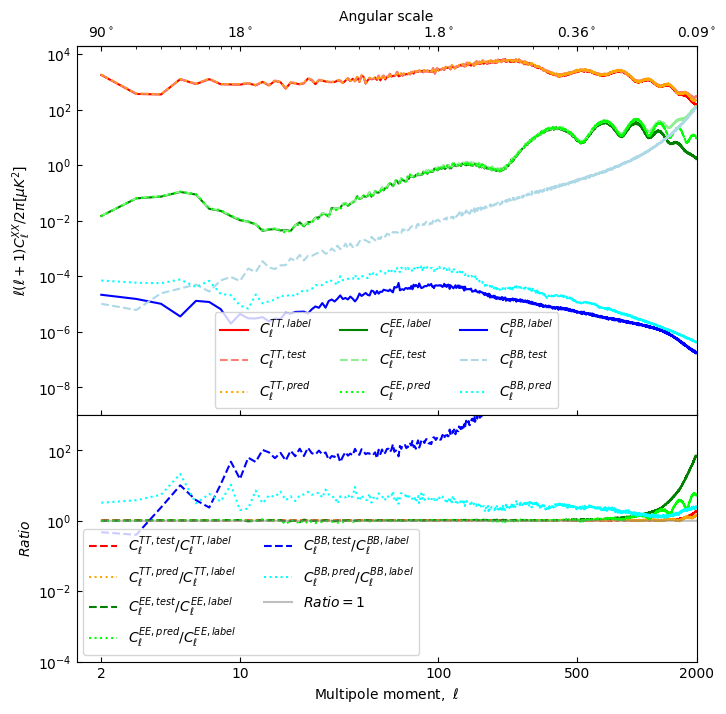

In [10]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


def plot_teb_cl(ell, T_label_cl, T_test_cl, T_pred_cl, E_label_cl, E_test_cl, E_pred_cl, B_label_cl, B_test_cl, B_pred_cl):
    factor = ell * (ell + 1) / (2 * np.pi)
    
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 1, hspace=0, wspace=0, width_ratios=[1], height_ratios=[1.5, 1])
    ax1, ax2 = gs.subplots(sharex=True)
    
    # Upper plot: Display T, E, B power spectra
    ax1.loglog(ell, factor*T_label_cl, label=r"$C_\ell^{TT, label}$", c='red')
    ax1.loglog(ell, factor*T_test_cl, label=r"$C_\ell^{TT, test}$", c='salmon', linestyle='--')
    ax1.loglog(ell, factor*T_pred_cl, label=r"$C_\ell^{TT, pred}$", c='orange', linestyle=':')
    
    ax1.loglog(ell, factor*E_label_cl, label=r"$C_\ell^{EE, label}$", c='green')
    ax1.loglog(ell, factor*E_test_cl, label=r"$C_\ell^{EE, test}$", c='lightgreen', linestyle='--')
    ax1.loglog(ell, factor*E_pred_cl, label=r"$C_\ell^{EE, pred}$", c='lime', linestyle=':')
    
    ax1.loglog(ell, factor*B_label_cl, label=r"$C_\ell^{BB, label}$", c='blue')
    ax1.loglog(ell, factor*B_test_cl, label=r"$C_\ell^{BB, test}$", c='lightblue', linestyle='--')
    ax1.loglog(ell, factor*B_pred_cl, label=r"$C_\ell^{BB, pred}$", c='cyan', linestyle=':')
    
    ax1.set_xlim(1.5, 2000)
    ax1.set_xticks([2, 10, 100, 500, 2000])
    ax1.set_xticklabels(['2', '10', '100', '500', '2000'])
    ax1.set_ylim(1e-9, 2e4)
    ax1.set_yticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4])
    ax1.set_yticklabels([r'$10^{-8}$', r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$', r'$10^2$', r'$10^4$'])
    ax1.set_ylabel(r"$\ell(\ell+1)C^{XX}_\ell/2\pi[\mu K^2]$")
    ax1.legend(loc='best', ncol=3)
    
    # Add angular scale
    ax_top = ax1.twiny()
    ax_top.spines.top.set_position(("axes", 1))
    ax_top.set_xscale("log")
    ax_top.set_xlim(1.5, 2000)
    ax_top.set_xticks([2, 10, 100, 500, 2000])
    ax_top.set_xticklabels([r'$90^\circ$', r'$18^\circ$', r'$1.8^\circ$', r'$0.36^\circ$', r'$0.09^\circ$'])
    ax_top.set_xlabel("Angular scale")
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.spines['right'].set_visible(False)
    
    # Lower plot: Display ratio
    ax2.loglog(ell, T_test_cl/T_label_cl, label=r"$C_\ell^{TT, test}/C_\ell^{TT, label}$", color='red', linestyle='--')
    ax2.loglog(ell, T_pred_cl/T_label_cl, label=r"$C_\ell^{TT, pred}/C_\ell^{TT, label}$", color='orange', linestyle=':')
    
    ax2.loglog(ell, E_test_cl/E_label_cl, label=r"$C_\ell^{EE, test}/C_\ell^{EE, label}$", color='green', linestyle='--')
    ax2.loglog(ell, E_pred_cl/E_label_cl, label=r"$C_\ell^{EE, pred}/C_\ell^{EE, label}$", color='lime', linestyle=':')
    
    ax2.loglog(ell, B_test_cl/B_label_cl, label=r"$C_\ell^{BB, test}/C_\ell^{BB, label}$", color='blue', linestyle='--')
    ax2.loglog(ell, B_pred_cl/B_label_cl, label=r"$C_\ell^{BB, pred}/C_\ell^{BB, label}$", color='cyan', linestyle=':')
    
    # Add reference line ratio=1
    ax2.loglog(ell, np.ones_like(ell), color='gray', label=r'$Ratio=1$', linestyle='-', alpha=0.5)
    
    ax2.minorticks_off()
    ax2.set_xlabel(r"$\rm{Multipole~moment,}~\ell$")
    ax2.set_ylabel(r"$Ratio$")
    ax2.set_ylim(1e-4, 1e3)
    ax2.set_yticks([1e-4, 1e-2, 1e0, 1e2])
    ax2.set_yticklabels([r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$', r'$10^{2}$'])
    ax2.set_xlim(1.5, 2000)
    ax2.set_xticks([2, 10, 100, 500, 2000])
    ax2.set_xticklabels(['2', '10', '100', '500', '2000'])
    ax2.legend(ncol=2, loc='lower left')
    
    for ax in [ax1, ax2]:
        ax.label_outer()
    
    plt.savefig("TEB_cl_ratio.pdf", bbox_inches='tight', pad_inches=0, dpi=300, format='pdf')
    plt.show()

                 
rearr = np.load("/home/nisl/Data/CMB_DeLensing/rearr_nside/rearr_nside2048.npy")


# Below are the trained results, no rotation, epochs=3000, theta=0, phi=0
T_label_map = np.load('result/T_pred_epochs_3000_0_0.npy').reshape(-1)[rearr]       
T_test_map = np.load('result/T_test_epochs_3000_0_0.npy').reshape(-1)[rearr]
T_pred_map = np.load('result/T_label_epochs_3000_0_0.npy').reshape(-1)[rearr]


E_label_map = np.load('result/E_pred_epochs_3000_0_0.npy').reshape(-1)[rearr]   
E_test_map = np.load('result/E_test_epochs_3000_0_0.npy').reshape(-1)[rearr]
E_pred_map = np.load('result/E_label_epochs_3000_0_0.npy').reshape(-1)[rearr]


B_label_map = np.load('result/B_pred_epochs_3000_0_0.npy').reshape(-1)[rearr]
B_test_map = np.load('result/B_test_epochs_3000_0_0.npy').reshape(-1)[rearr]
B_pred_map = np.load('result/B_label_epochs_3000_0_0.npy').reshape(-1)[rearr]


T_label_cl = hp.anafast(T_label_map, lmax=2000)
T_test_cl = hp.anafast(T_test_map, lmax=2000)
T_pred_cl = hp.anafast(T_pred_map, lmax=2000)

E_label_cl = hp.anafast(E_label_map, lmax=2000)
E_test_cl = hp.anafast(E_test_map, lmax=2000)
E_pred_cl = hp.anafast(E_pred_map, lmax=2000)

B_label_cl = hp.anafast(B_label_map, lmax=2000)
B_test_cl = hp.anafast(B_test_map, lmax=2000)
B_pred_cl = hp.anafast(B_pred_map, lmax=2000)

ell = np.arange(2, len(T_label_cl))
T_label_cl = T_label_cl[2:]
T_test_cl = T_test_cl[2:]
T_pred_cl = T_pred_cl[2:]

E_label_cl = E_label_cl[2:]
E_test_cl = E_test_cl[2:]
E_pred_cl = E_pred_cl[2:]

B_label_cl = B_label_cl[2:]
B_test_cl = B_test_cl[2:]
B_pred_cl = B_pred_cl[2:]

# Use new plotting function
plot_teb_cl(ell, T_label_cl, T_test_cl, T_pred_cl, E_label_cl, E_test_cl, E_pred_cl, B_label_cl, B_test_cl, B_pred_cl)
